# Determine if an eccentric binary will eclipse

https://ui.adsabs.harvard.edu/abs/2007PASP..119..986B/abstract

http://www.jdso.org/volume13/number2/Harfenist_189-199.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, constants

%matplotlib inline

In [2]:
def getafromP(m1, m2, P):
    #returns the semimajor axis from the period and stellar masses
    return (((P**2.) * constants.G * (m1 + m2) / (4*np.pi**2.))**(1./3.)).decompose().to(units.AU)

In [3]:
#from our code for circular binaries
def checkEclipse(r1,r2,rp,inclination):
    ratio = (r1 + r2)/rp #rp = 2a for circular orbits
    if (ratio <= 1):
        theta = np.arcsin(ratio)*180./np.pi
        min_incl = 90. - theta
        max_incl = 90. + theta
        if (inclination <= min_incl or inclination >= max_incl):
            return False
    return True

In [16]:
r1 = 1.*units.solRad
r2 = 0.5*units.solRad
per = 100.*units.day
m1 = 1.*units.solMass
m2 = 0.5*units.solMass
semi = getafromP(m1, m2, per)
print(semi)

inclination = 90.


print(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, inclination))

0.4826490641022738 AU
True


In [17]:
N = 100
inc = np.linspace(88, 90, N)
testCirc = [checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, i) for i in inc]
print(testCirc)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


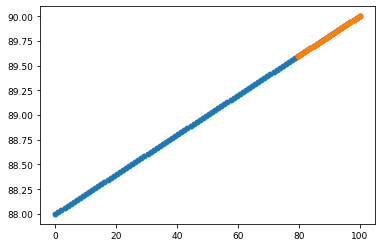

In [18]:
f,ax = plt.subplots()
index = np.linspace(0,N,N)
ax.scatter(index, inc)
ecl = np.where(testCirc)
ax.scatter(index[ecl],inc[ecl])


In [19]:
#try using the python code radvel :https://radvel.readthedocs.io/en/latest/index.html
#https://radvel.readthedocs.io/_/downloads/en/latest/pdf/
import radvel

In [30]:
tp = 100 #time of periastron 
ecc = 0.9 # eccentricity
omega = 0.12345 #argument of peri (radians)

#primary
ttrans = radvel.orbit.timeperi_to_timetrans(np.array([tp]), per.to(units.day).value, ecc, omega)
ta = radvel.orbit.true_anomaly(ttrans, np.array([tp]), per.to(units.day).value, ecc)

rp1 = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta))
rp2 = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta + np.pi))
rp = rp1 + rp2

print(ttrans,ta, rp1, rp2, rp, 2.*semi)

#secondary
ttrans = radvel.orbit.timeperi_to_timetrans(np.array([tp]), per.to(units.day).value, ecc, omega, secondary=True)
ta = radvel.orbit.true_anomaly(ttrans, np.array([tp]), per.to(units.day).value, ecc)

rp1 = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta))
rp2 = semi*(1. - ecc*ecc)/(1. + ecc*np.cos(ta + np.pi))
rp = rp1 + rp2

print(ttrans,ta, rp1, rp2, rp, 2.*semi)

[100.78818499] 1.470058867665504 0.08409210783409979 AU 0.10082943995143769 AU 0.1849215477855375 AU 0.9652981282045476 AU
[198.88231953] -1.7016222304054447 0.10390224937653933 AU 0.08206791464943032 AU 0.18597016402596966 AU 0.9652981282045476 AU


In [29]:
radvel.orbit.true_anomaly(np.array([100]), np.array([100]), per.to(units.day).value, ecc)

0.0

In [24]:
N = 100
inc = np.linspace(88, 90, N)
testCirc = []
testEcc = []
for i in inc:
    testCirc.append(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , 2.*semi.to(units.AU).value, i))
    testEcc.append(checkEclipse(r1.to(units.AU).value, r2.to(units.AU).value , rp.to(units.AU).value, i))

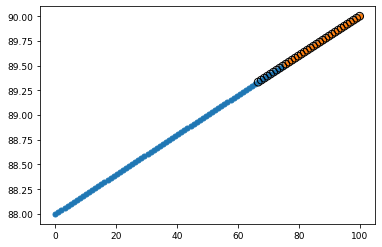

In [30]:
f,ax = plt.subplots()
index = np.linspace(0,N,N)

ax.scatter(index, inc)
ecl = np.where(testCirc)
ax.scatter(index[ecl],inc[ecl])
ecl = np.where(testEcc)

ax.scatter(index[ecl],inc[ecl], facecolors='none', edgecolors='black', s=60)




In [ ]:
#verify this with ellc?
#I think I will have to rerun these, but I may not have to rerun everything.  
#  If I take those that weren't observable, then choose a random argument of peri and t0, then check for eclipse
#  and only run those that will eclipse.  Will that work?  But then I will also need to check the observable ones and 
#  limit those somehow... it will be much cleaner to just rerun everything... sigh!